# **Создание IP-адресов**
- **ноутбуки лучше просматривать** на Github pages, т.к. при просмотре прямо в репозитории могут быть проблемы с отображением, например, обрезка вывода с широкими датафреймами. **Если в адресной строке браузера есть** `iaroslav-dzh.github.io`, то вы уже на Github pages.  
Ссылки:
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/04_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_ip_%D0%B0%D0%B4%D1%80%D0%B5%D1%81%D0%BE%D0%B2.html)** на этот ноутбук
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/)** на страницу со всеми ноутбуками  

**Информация о ноутбуке**  
- создание ip адресов для клиентов и под фрод. Под фрод для случаев если это compromised client фрод.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
import ipaddress
import pyarrow
from data_generator.utils import load_configs

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.chdir("..")
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

In [6]:
# Базовые конфиги
base_cfg = load_configs("./config/base.yaml")

# Пути к файлам
data_paths = base_cfg["data_paths"]

In [17]:
clients = pd.read_parquet(data_paths["clients"]["clients"])
cities = gpd.read_file(data_paths["base"]["cities"])
city_centers_gdf = gpd.read_file(data_paths["base"]["city_centers"])

<br>

# **Генерация ip-адресов для клиентов**
- понадобится для онлайн покупок и, возможно, переводов
- оригинальные ip адреса используются в генерации легальных транзакций и в генерации активности дропов

# 1. Загрузка и распаковка ip адресов 

In [7]:
ru_ip_ranges = pd.read_csv("./data/raw/geo/Russia_and_Belarus_IP_ranges", header=None)

In [8]:
ru_ip_ranges.columns = ["range"]

In [9]:
ru_ip_ranges["range"] = ru_ip_ranges["range"].str.strip()

In [10]:
ru_ip_ranges.shape

(22508, 1)

In [11]:
ru_ip_ranges.head()

,range
0,2.60.0.0/19
1,2.60.32.0/19
2,2.60.64.0/19
3,2.60.96.0/19
4,2.60.128.0/19


In [12]:
ru_ip_ranges_50 = ru_ip_ranges[:50].copy()
ru_ip_ranges_50.shape

(50, 1)

In [13]:
# функция извлечения возможных ip-адресов из диапазона

def get_ips_from_range(ip_range):
    unpacked_ips = []
    # Создаём объект сети
    network = ipaddress.ip_network(ip_range)
    
    # Вывод всех хостов в сети (исключая сетевой и broadcast-адрес)
    for ip in network.hosts():
        unpacked_ips.append(str(ip))
    return pd.Series(unpacked_ips)

In [14]:
# непосредственно извлечение ip-адресов при помощи функции

unpacked_ips_glob = pd.concat([get_ips_from_range(ip_range) for ip_range in ru_ip_ranges_50.range.values], ignore_index=True)
unpacked_ips_glob.nunique()

606876

In [15]:
unpacked_ips_glob.tail()

606871    5.8.31.250
606872    5.8.31.251
606873    5.8.31.252
606874    5.8.31.253
606875    5.8.31.254
dtype: object

<br>

## 2. Присвоение ip клиентам

In [21]:
clients.head(2)

,client_id,birth_date,sex,region,city,lat,lon,city_id,home_ip
0,1,1995-12-07,female,Рязанская,Рязань,54.625457,39.735999,18,2.60.0.1
1,2,1970-01-29,male,Москва,Москва,55.753879,37.620373,1,2.60.0.2


In [19]:
clients_rows = clients.shape[0]
clients_rows

5369

In [20]:
clients["home_ip"] = unpacked_ips_glob[:clients_rows].copy()
clients.head()

,client_id,birth_date,sex,region,city,lat,lon,city_id,home_ip
0,1,1995-12-07,female,Рязанская,Рязань,54.625457,39.735999,18,2.60.0.1
1,2,1970-01-29,male,Москва,Москва,55.753879,37.620373,1,2.60.0.2
2,3,1965-10-03,female,Москва,Москва,55.753879,37.620373,1,2.60.0.3
3,4,1981-11-25,male,Ростовская,Ростов-на-Дону,47.222436,39.718787,5,2.60.0.4
4,5,1985-06-27,female,Ростовская,Ростов-на-Дону,47.222436,39.718787,5,2.60.0.5


### **Выгрузка `clients` с ip адресами в файл**

In [22]:
# данные понадобятся в других ноутбуках

clients.to_parquet(data_paths["clients"]["clients"], engine="pyarrow")

<br>

## 2. Создание фрод ip адресов

In [23]:
# умножим количество имеющихся городов в 100 раз для добавления 7700 мошеннических/подозрительных ip адресов

online_fraud_cities = pd.concat([city_centers_gdf for _ in range(100)], ignore_index=True)
print(online_fraud_cities.shape)
online_fraud_cities.tail()

(7700, 4)


,city,lat,lon,geometry
7695,Петрозаводск,61.789090,34.359626,POINT (34.35963 61.78909)
7696,Таганрог,47.209491,38.935154,POINT (38.93515 47.20949)
7697,Нижневартовск,60.939738,76.569621,POINT (76.56962 60.93974)
7698,Йошкар-Ола,56.634376,47.899845,POINT (47.89984 56.63438)
7699,Братск,56.151395,101.633989,POINT (101.63399 56.1514)


In [24]:
# возьмем 7700 ip с конца серии. home ip клиентов мы сзяли с начала серии. Серия очень большая: 600+ тыс адресов
fraud_ip_ser = unpacked_ips_glob.iloc[np.r_[-online_fraud_cities.shape[0]:0]].reset_index(drop=True)
fraud_ip_ser

0       5.3.252.223
1       5.3.252.224
2       5.3.252.225
3       5.3.252.226
4       5.3.252.227
           ...     
7695     5.8.31.250
7696     5.8.31.251
7697     5.8.31.252
7698     5.8.31.253
7699     5.8.31.254
Length: 7700, dtype: object

In [25]:
# соединим названия городов и ip адреса

fraud_ips = pd.concat([online_fraud_cities, fraud_ip_ser], axis=1, \
                      ignore_index=False).rename(columns={0:"fraud_ip"})
print(fraud_ips.shape)
fraud_ips.tail()

(7700, 5)


,city,lat,lon,geometry,fraud_ip
7695,Петрозаводск,61.789090,34.359626,POINT (34.35963 61.78909),5.8.31.250
7696,Таганрог,47.209491,38.935154,POINT (38.93515 47.20949),5.8.31.251
7697,Нижневартовск,60.939738,76.569621,POINT (76.56962 60.93974),5.8.31.252
7698,Йошкар-Ола,56.634376,47.899845,POINT (47.89984 56.63438),5.8.31.253
7699,Братск,56.151395,101.633989,POINT (101.63399 56.1514),5.8.31.254


In [26]:
# Проверка результата на нескольких случайных городах
fraud_ips_six_cities = fraud_ips.query("city in ['Нижний Новгород', 'Калининград', 'Казань', 'Самара', 'Братск', 'Москва']") \
                            [["city", "geometry"]].groupby("city", as_index=False).head(1).reset_index(drop=True)

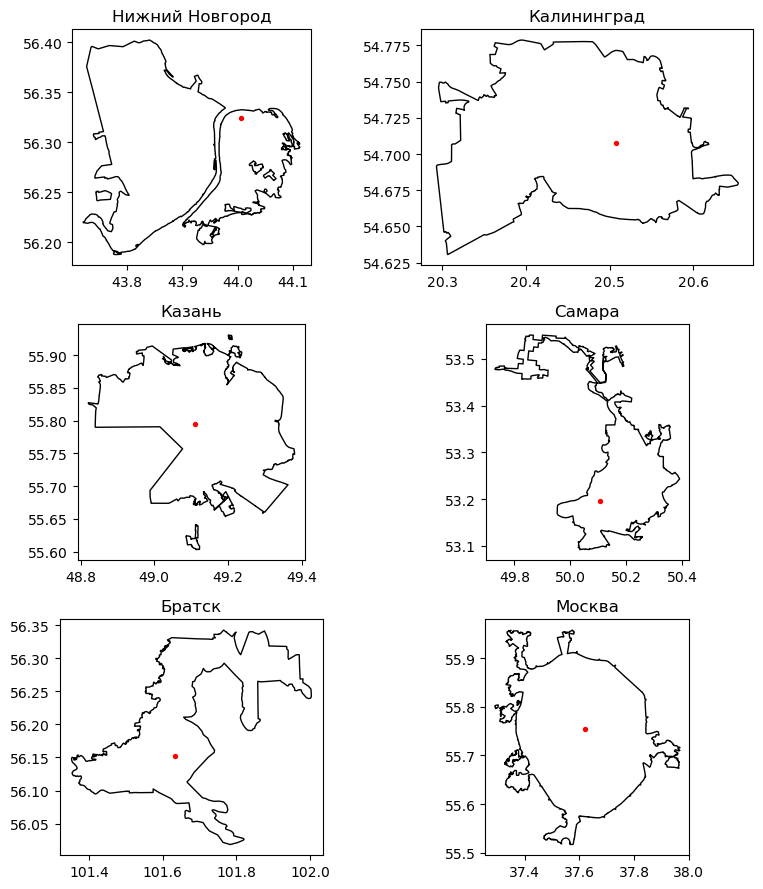

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,9))
six_random_cities_names = [['Нижний Новгород', 'Калининград'], ['Казань', 'Самара'], ['Братск', 'Москва']]


for row, two_cities in zip(axes, six_random_cities_names):
    for ax, city in zip(row, two_cities):
        gpd.GeoSeries(cities.query("city == @city").geometry).boundary.plot(linewidth=1, edgecolor="black", ax=ax)
        gpd.GeoSeries(fraud_ips_six_cities.query("city == @city").geometry).plot(ax=ax, linewidth=1, color="red", markersize=8)
        ax.set_title(city)
plt.tight_layout()
plt.show()

In [28]:
# удалим колонку geometry. Она больше не нужна

fraud_ips.drop(columns="geometry", inplace=True)

### **Выгрузка fraud_ips в файл**

In [29]:
fraud_ips.to_parquet(data_paths["base_fraud"]["fraud_ips"], engine="pyarrow")